<a href="https://colab.research.google.com/github/mdehghani86/AppliedGenAI/blob/main/GenAI_BeerGame_V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =================================================
# 📌 Essential Imports for Beer Game Simulation
# =================================================

import re        # Regular expressions for text processing
import random    # Random number generation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests  # HTTP requests for fetching data (e.g., API keys)
import ipywidgets as widgets  # Interactive widgets for UI elements
from IPython.display import display, HTML  # Display formatted output in Jupyter


In [2]:
"""
=========================================================
🌟 OpenAI API Key Loader and Validator Script
=========================================================
"""
!pip install openai==0.28.0

import requests
import os
import openai


In [3]:
# =================================================
# 🔑 Load OpenAI API Key from Dropbox
# =================================================

dropbox_url = 'https://www.dropbox.com/scl/fi/z3tai9qqmuamab8hixd42/OpenAI_Key.txt?rlkey=en1fx9yqk3u1l87vqhk3xg5tm&dl=1'

# Load API Key once
if "OPENAI_API_KEY" not in os.environ:
    try:
        os.environ["OPENAI_API_KEY"] = requests.get(dropbox_url).text.strip()
        openai.api_key = os.getenv("OPENAI_API_KEY")
    except Exception as e:
        print(f"❌ API Key Load Error: {e}")

import openai

# List available models under the OpenAI API key
try:
    models = openai.Model.list()
    model_ids = [model['id'] for model in models['data']]
    print("✅ Available OpenAI Models:")
    print("\n".join(model_ids))
except Exception as e:
    print(f"❌ Error retrieving models: {e}")


✅ Available OpenAI Models:
gpt-4o-audio-preview-2024-10-01
gpt-4o-mini-audio-preview
gpt-4o-2024-08-06
gpt-4o-mini-audio-preview-2024-12-17
gpt-4o-mini-realtime-preview
dall-e-2
gpt-4o
gpt-4o-mini
gpt-4o-mini-2024-07-18
gpt-3.5-turbo
o1-preview-2024-09-12
gpt-3.5-turbo-0125
o1-preview
gpt-3.5-turbo-instruct
babbage-002
o1-mini-2024-09-12
whisper-1
dall-e-3
gpt-4o-realtime-preview-2024-10-01
gpt-4-1106-preview
omni-moderation-latest
omni-moderation-2024-09-26
gpt-4-0613
tts-1-hd-1106
gpt-4o-2024-11-20
gpt-4
chatgpt-4o-latest
tts-1-hd
davinci-002
text-embedding-ada-002
gpt-4o-2024-05-13
gpt-4-turbo
text-embedding-3-large
tts-1
tts-1-1106
gpt-3.5-turbo-instruct-0914
gpt-4-turbo-preview
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4o-audio-preview
text-embedding-3-small
gpt-4-turbo-2024-04-09
gpt-3.5-turbo-1106
gpt-3.5-turbo-16k
gpt-4o-audio-preview-2024-12-17
gpt-4o-realtime-preview-2024-12-17
gpt-4o-realtime-preview
gpt-4-0125-preview
o1-mini


In [4]:
# ==== Define the OpenAI Call Function ====
def call_ChatGPT(user_prompt, system_prompt="You are a supply chain expert for the Beer Game.",
                 model="gpt-4-turbo", temperature=0.7, max_tokens=500):
    """
    Calls OpenAI's ChatGPT API with configurable parameters.

    Parameters:
        user_prompt (str): Required. The user's input question or command.
        system_prompt (str): Optional. Context setting for the AI (default: Beer Game supply chain expert).
        model (str): Optional. OpenAI model to use (default: "gpt-4.5-turbo").
        temperature (float): Optional. Controls randomness (default: 0.7).
        max_tokens (int): Optional. Limits response length (default: 500).

    Returns:
        str: ChatGPT's response.
    """
    if not user_prompt:
        return "❌ Error: A user prompt is required."

    try:
        response = openai.ChatCompletion.create(
            model=model,
            temperature=temperature,
            max_tokens=max_tokens,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
        )
        return response['choices'][0]['message']['content']

    except openai.error.AuthenticationError:
        return "❌ Invalid API key. Please check your API credentials."

    except Exception as e:
        return f"❌ An unexpected error occurred: {e}"

In [5]:
# ---------- Demand Variability ----------
def define_demand_distribution(demand_type, period=None):
    """
    Generates demand directly based on the selected type.

    Parameters:
        - demand_type (str): The type of demand ('Market Fluctuation' or 'Seasonal Demand').
        - period (int, optional): The current period, required for 'Seasonal Demand'.

    Returns:
        - demand (int): The generated numeric demand value.
    """
    if demand_type == "Market Fluctuation":
        # Generate random demand using a uniform distribution
        return np.random.randint(9, 15)  # B = 12, V = 3

    elif demand_type == "Seasonal Demand":
        if period is None:
            raise ValueError("Period is required for Seasonal Demand.")

        # Generate demand following a 5-period cycle with randomness
        cycle_phase = period % 5
        seasonal_factors = [
            np.random.randint(-4, 0),  # Low
            np.random.randint(-2, 1),  # Medium
            np.random.randint(1, 2),   # High
            np.random.randint(3, 6),   # Peak
            np.random.randint(-2, 2)   # Medium again
        ]
        return max(5, min(20, 11 + seasonal_factors[cycle_phase]))  # Clamp demand between 5 and 20

    else:
        raise ValueError("Invalid demand type selected.")


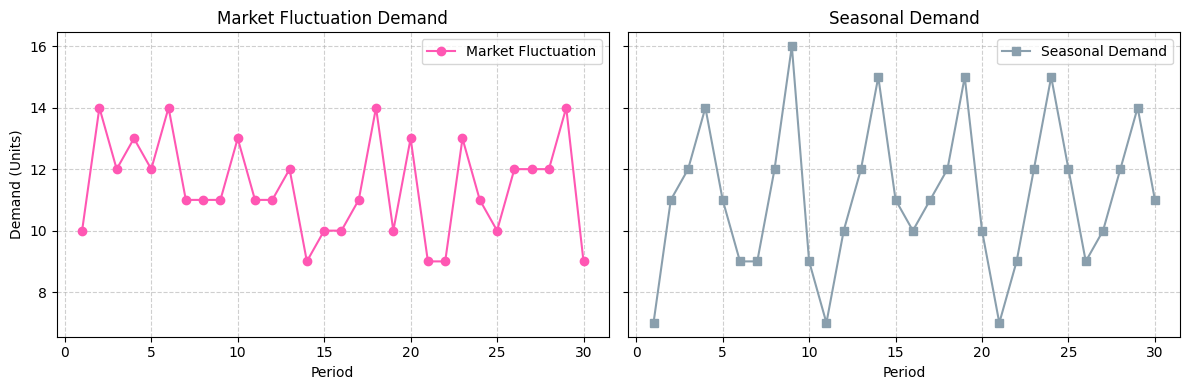

In [6]:
# ==== Simulating Demand for Market Fluctuation and Seasonal Demand ====
"""
Simulates and plots demand for 30 periods:
1. Market Fluctuation (random variations).
2. Seasonal Demand (5-period cycle with randomness).
"""

# Number of periods for simulation
periods = 30

# Generate demand for 30 periods
market_demand = [define_demand_distribution("Market Fluctuation") for _ in range(periods)]
seasonal_demand = [define_demand_distribution("Seasonal Demand", p) for p in range(periods)]  # Pass period as positional

# ==== Plot Results Side by Side ====
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Market Fluctuation Demand Plot
axes[0].plot(range(1, periods + 1), market_demand, marker='o', linestyle='-', color='#FF57B3', label="Market Fluctuation")
axes[0].set_title("Market Fluctuation Demand")
axes[0].set_xlabel("Period")
axes[0].set_ylabel("Demand (Units)")
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# Seasonal Demand Plot
axes[1].plot(range(1, periods + 1), seasonal_demand, marker='s', linestyle='-', color='#8A9FAD', label="Seasonal Demand")
axes[1].set_title("Seasonal Demand")
axes[1].set_xlabel("Period")
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()


In [7]:
def generate_order_quantity(table_part1, table_part2, holding_cost, backorder_cost, justification=False):
    """
    Generates an optimal order quantity based on inventory and historical data.
    Uses OpenAI's API via the `call_ChatGPT` function for decision-making.

    Parameters:
        - table_part1 (DataFrame): Inventory-related data (last 3 weeks).
        - table_part2 (DataFrame): Demand, costs, and order data (last 3 weeks).
        - holding_cost (int): Cost per unit of holding inventory.
        - backorder_cost (int): Cost per unit of backorder.
        - justification (bool): Whether to return a justification.

    Returns:
        - order_quantity (int): Suggested order quantity.
        - justification_text (str): Explanation (if justification=True).
    """

    # Extract recent data summaries
    trend_summary = "Recent weekly data:\n"
    for week in range(min(3, len(table_part1))):  # Limit to last 3 weeks
        week_data_1 = table_part1.iloc[week]
        week_data_2 = table_part2.iloc[week]

        trend_summary += (
            f"Week {week_data_1['Week']}: "
            f"Inventory: {week_data_1['Inventory']}, "
            f"Incoming Shipments: {week_data_1['Incoming Shipping']}, "
            f"Order Quantity: {week_data_2['Order Quantity']}, "
            f"Demand: {week_data_2['Demand']}, "
            f"Excess Inventory: {week_data_2['Excess Inventory']}, "
            f"Backorder: {week_data_2['Backorder']}, "
            f"Holding Cost: {week_data_2['Holding Cost']}, "
            f"Backorder Cost: {week_data_2['Backorder Cost']}.\n"
        )

    # Create the prompt for OpenAI
    prompt = (
        f"Based on the following recent inventory data:\n{trend_summary}\n"
        f"- Holding cost per unit: {holding_cost}\n"
        f"- Backorder cost per unit: {backorder_cost}\n\n"
        "Determine the optimal order quantity for next week.\n"
        "Use expected inventory calculations:\n"
        "Expected Inventory = Current Inventory - Expected Demand (which varies between 5 and 20) + Incoming Shipments.\n\n"
        "Suggest an order quantity that balances holding and backorder costs while ensuring optimal stock levels.\n\n"
        "Please provide your result explicitly in the following format with no additional text:\n"
        "'Suggest Order Quantity is: [your calculated quantity]'."
    )

    if justification:
        prompt += " Also, provide a short justification for your decision."

    # Call OpenAI API using the optimized function
    response_text = call_ChatGPT(prompt, system_prompt="You are an inventory optimization assistant.")

    # Extract order quantity from AI response
    match = re.search(r'\b\d+\b', response_text)
    order_quantity = int(match.group()) if match else None

    return order_quantity, (response_text if justification else None)


In [8]:
import random
import pandas as pd

def get_order_quantity(approach, table_part1, table_part2, holding_cost, backorder_cost):
    """
    This function determines the order quantity based on the selected approach.
    It can either take manual input from the user, use a GenAI-assisted suggestion,
    fully automate the decision-making with GenAI, or calculate the average demand.

    Parameters:
    - approach: The approach used to determine the order quantity ('Manual', 'GenAI-Assisted', 'Full Gen-AI', 'Average').
    - table_part1: A part of the table with relevant inventory and shipment information.
    - table_part2: A part of the table with order quantity, demand, and cost data.
    - holding_cost: The cost of holding inventory for a given period.
    - backorder_cost: The cost incurred for not fulfilling an order on time.

    Returns:
    - order_quantity: The determined order quantity (either from user input, average calculation, or GenAI).
    - justification_text: A justification for the decision, if applicable.
    """

    # Print the approach in green every time the function is used
    print(f"Using approach: \033[92m{approach}\033[0m")  # Only the approach is colored green

    # Handle the 'average' approach
    if approach == 'average':
        # Calculate the average of non-null "Demand" values
        average_demand = table_part2['Demand'].dropna().mean()

        # If all demand values are null, generate a random integer between 8 and 12
        if pd.isna(average_demand):
            average_demand = random.randint(8, 12)
        else:
            # Convert the average to an integer
            average_demand = int(round(average_demand))

        print(f"Average Demand: {average_demand}")
        justification_text = "The order quantity was calculated as the average of non-null demand values or a random value if all were null."
        return average_demand, justification_text

    # Handle the 'Manual' approach
    elif approach == 'Manual':
        # If the approach is 'Manual', the user enters the order quantity
        order_quantity = int(input("Enter the order quantity manually: "))
        return order_quantity, None

    # Handle the 'GenAI-Assisted' or 'Full Gen-AI' approach
    elif approach == 'GenAI-Assisted' or approach == 'Full Gen-AI':
        # If the approach is 'GenAI-Assisted' or 'Full Gen-AI', GenAI provides a suggestion
        suggested_order, justification = generate_order_quantity(
            table_part1, table_part2, holding_cost, backorder_cost, justification=True
        )

        # Print the suggestion and justification
        print(f"AI Suggestion: {suggested_order}")
        print(f"Justification: {justification}")

        # Get the final order quantity from the user for GenAI-assisted approach
        if approach == 'GenAI-Assisted':
            order_quantity = int(input(f"Enter the final order quantity for {suggested_order}: "))
        else:
            # If the approach is 'Full Gen-AI', use the suggestion without modification
            order_quantity = suggested_order

        return order_quantity, justification

    else:
        # Raise an error if the provided approach is invalid
        raise ValueError("Invalid approach specified. Choose 'Manual', 'GenAI-Assisted', 'Full Gen-AI', or 'Average'.")


In [9]:
# ---------- Initial Inventory Values for Each Role ----------
initial_inventories = {
    'Retailer': 10,
    'Wholesaler': 15,
    'Distributor': 20,
    'Factory': 25
}

# ---------- Cost Parameters ----------
holding_cost = 1            # Cost per unit of inventory held
backorder_cost = 2          # Cost per unit of backorder (penalty for unfilled demand)

# ---------- Lead Times ----------
lead_times = {
    'Retailer': 1,
    'Wholesaler': 2,
    'Distributor': 3,
    'Factory': 3
}

# ---------- Incoming Shipments ----------
incoming_shipments = {
    'Retailer': [(5, 1)],
    'Wholesaler': [(6, 1), (4, 2)],
    'Distributor': [(8, 1), (6, 2), (5, 3)],
    'Factory': [(10, 1), (8, 2), (7, 3)]
}

In [10]:
import random
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

# ---------- Seed for Reproducibility ----------
random.seed(42)  # Ensures AI assignments remain the same on reruns

def generate_welcome_message(role, demand_type, weeks, user_name, players, approach):
    """
    Displays a styled welcome message with user selections and player flow.
    """
    # 🎮 Clean & minimal emoji use for readability
    message = f"""
    <h2>Welcome, {user_name}! 🚀</h2>
    <p><b>Game Settings:</b></p>
    <ul>
        <li><b>Role:</b> {role}</li>
        <li><b>Demand Type:</b> {demand_type}</li>
        <li><b>Number of Weeks:</b> {weeks}</li>
        <li><b>Approach:</b> {approach}</li>
    </ul>
    <p><b>Players in the Game:</b></p>
    <p>{players}</p>
    <p>Let's begin!</p>
    """

    # Display the message
    display(HTML(message))


def generate_players(user_name, role):
    """
    Generates a list of players in the game, inserting the user into the correct role
    and assigning AI players to other roles.
    """
    # Define the fixed role order: Retailer -> Supplier -> Wholesaler -> Manufacturer
    fixed_roles = ['Retailer', 'Supplier', 'Wholesaler', 'Manufacturer']

    # List of AI player names
    ai_names = ['AI-Retail', 'AI-Supply', 'AI-Wholesale', 'AI-Manufacture']

    players_flow = []  # List to store player roles and names

    for r in fixed_roles:
        if r == role:
            players_flow.append(f"<strong>{user_name}</strong> ({r})")  # Add the user
        else:
            ai_name = ai_names.pop(0)  # Assign AI names dynamically
            players_flow.append(f"<strong>{ai_name}</strong> ({r})")  # Assign AI

    return " ➡️ ".join(players_flow)  # Use arrow emoji for better visual clarity


# ---------- Define Input Widgets ----------
role_input = widgets.Dropdown(
    options=['Retailer', 'Supplier', 'Wholesaler', 'Manufacturer'],
    value='Retailer',
    description='Role:',
)

demand_input = widgets.Dropdown(
    options=['Market Fluctuation', 'Seasonal Demand'],
    value='Market Fluctuation',
    description='Demand:',
)

weeks_input = widgets.IntText(
    value=12,
    description='Weeks:',
    min=1,
)

name_input = widgets.Text(
    value='User',
    description='Your Name:',
)

approach_input = widgets.Dropdown(
    options=['Manual', 'GenAI-Assisted', 'Full Gen-AI'],
    value='Manual',
    description='Approach:',
)

start_button = widgets.Button(description="🚀 Start Game")


def on_start_button_click(b):
    """
    Handles the 'Start Game' button click, clears previous output, captures inputs, and displays the welcome message.
    """
    # Clear previous outputs to prevent stacking messages
    clear_output(wait=True)

    # Redisplay input widgets & button after clearing
    display(role_input, demand_input, weeks_input, name_input, approach_input, start_button)

    # Capture user inputs
    role = role_input.value
    demand_type = demand_input.value
    weeks = weeks_input.value
    user_name = name_input.value
    approach = approach_input.value

    # Generate players list
    players = generate_players(user_name, role)

    # Display the welcome message
    generate_welcome_message(role, demand_type, weeks, user_name, players, approach)

Dropdown(description='Role:', options=('Retailer', 'Supplier', 'Wholesaler', 'Manufacturer'), value='Retailer'…

Dropdown(description='Demand:', options=('Market Fluctuation', 'Seasonal Demand'), value='Market Fluctuation')

IntText(value=5, description='Weeks:')

Text(value='User', description='Your Name:')

Dropdown(description='Approach:', options=('Manual', 'GenAI-Assisted', 'Full Gen-AI'), value='Manual')

Button(description='🚀 Start Game', style=ButtonStyle())

In [11]:
from IPython.display import clear_output, display, HTML
import pandas as pd
import matplotlib.pyplot as plt

# Main function to generate supply chain table for all roles based on the selected approach and parameters
def generate_supply_chain_table_for_all_roles(detailed_summary=False):
    """
    This function generates supply chain data for all roles (Retailer, Wholesaler, Distributor, Factory) over a
    specified number of weeks. The data includes inventory levels, order quantities, backorders, costs, and incoming shipments.

    Parameters:
    - detailed_summary: Boolean indicating if detailed weekly summaries should be displayed.

    Returns:
    - all_tables: A dictionary containing the generated data tables for each role.
    """

    # Get the values from the input widgets
    role_to_display = role_input.value  # Default to user-selected role from widget
    approach = approach_input.value  # Use approach from input widget
    weeks = weeks_input.value  # Use number of weeks from input widget
    demand_type = demand_input.value  # Use demand type from input widget

    all_tables = {}  # Initialize dictionary to store the tables for each role
    previous_orders = {}  # Dictionary to track order quantities for each role
    previous_orders["Retailer"] = define_demand_distribution(demand_type, period=0)  # Initial customer demand for Retailer

    previous_role = None  # Initialize previous_role to None for loop

    # Iterate through each role in order: Retailer -> Wholesaler -> Distributor -> Factory
    for role in ["Retailer", "Wholesaler", "Distributor", "Factory"]:
        data = []  # List to store data for the current role
        inventory = initial_inventories[role]  # Initial inventory for the role
        backorder = 0  # Backorder for the role, initialized to 0
        cumulative_total_cost = 0  # Cumulative total cost, initialized to 0
        incoming_shippings = incoming_shipments[role]  # Incoming shipments for the role

        # Add Week 0 as the initial setup week
        data.append({
            "Week": 0,
            "Role": role,
            "Inventory": inventory,
            "Incoming Shipping": incoming_shippings.copy(),
            "Order Quantity": None,
            "Demand": None,
            "Excess Inventory": None,
            "Backorder": None,
            "Holding Cost": None,
            "Backorder Cost": None,
            "Total Cost": cumulative_total_cost
        })

        # Loop over each week (from 1 to the number of weeks specified by the user)
        for i in range(1, weeks + 1):
            # Set demand based on the role's type of demand
            if role == "Retailer":
                demand = define_demand_distribution(demand_type, i)  # Generate customer demand for Retailer
            else:
                # Get demand from the Order Quantity of the previous role’s table_part2 for the same week
                demand = all_tables[previous_role][1].loc[
                    all_tables[previous_role][1]['Week'] == i, 'Order Quantity'
                ].values[0]

            # Process incoming shipments that have arrived this week
            arrived_shipments = [shipment[0] for shipment in incoming_shippings if shipment[1] == i]
            arrived_shipments = [shipment for shipment in arrived_shipments if shipment is not None]  # Remove None values
            total_arrived = sum(arrived_shipments)  # Calculate total arrived shipments for the week
            incoming_shippings = [shipment for shipment in incoming_shippings if shipment[1] != i]

            # Generate the order quantity based on the selected approach (Manual, GenAI-Assisted, or Full Gen-AI)
            temp_table_part1 = pd.DataFrame(data)[["Week", "Role", "Inventory", "Incoming Shipping"]]
            temp_table_part2 = pd.DataFrame(data)[[
                "Week", "Role", "Order Quantity", "Demand", "Excess Inventory", "Backorder",
                "Holding Cost", "Backorder Cost", "Total Cost"
            ]]

            if detailed_summary and role == role_to_display:
                # Clear the output of the current cell
                clear_output(wait=True)
                separator = "=" * 40  # Separator for visibility
                week_text = f"{i}"

                # Display the separator and centered "Week {i}" text in purple color using HTML
                display(HTML(f"<h3 style='text-align:center; color: purple;'>{week_text.center(len(separator))}</h3>"))
                display(HTML(f"<hr style='border-top: 3px solid #8a2be2; width: 100%;'>"))

                # Display summary and detailed data for the current week in a table
                summary_df = pd.DataFrame(data)[["Week", "Role", "Inventory", "Incoming Shipping"]].head(i + 1)
                detailed_df = pd.DataFrame(data)[[
                    "Week", "Role", "Order Quantity", "Demand", "Excess Inventory", "Backorder",
                    "Holding Cost", "Backorder Cost", "Total Cost"
                ]].head(i)

                # Merge both DataFrames on "Week" and display the combined table as HTML
                combined_df = pd.merge(summary_df, detailed_df, on=["Week", "Role"], how="outer")
                display(HTML(combined_df.to_html(index=False)))
                display(HTML(f"<hr style='border-top: 3px solid #8a2be2; width: 100%;'>"))

                # Plotting the order and demand for the current role
                plt.figure(figsize=(10, 4))
                plt.plot(combined_df['Week'], combined_df['Order Quantity'], label="Order Quantity",
                         marker='o', linestyle='-', color='blue')
                plt.plot(combined_df['Week'], combined_df['Demand'], label="Demand",
                         marker='x', linestyle='--', color='red')
                plt.title(f"Order Quantity vs Demand for {role} (Week {i})", fontsize=14)
                plt.xlabel("Week", fontsize=12)
                plt.ylabel("Quantity", fontsize=12)
                plt.legend(loc='lower right')
                plt.grid(True, which='both', axis='y')  # Only show horizontal grid lines
                plt.xticks(ticks=combined_df['Week'], labels=[f"Week {x}" for x in combined_df['Week']], rotation=45)
                plt.ylim(bottom=0)  # Set the y-axis to start from 0
                # Handle NaN values by using 'fillna' with 0 before calculating the maximum
                max_y = int(combined_df[['Order Quantity', 'Demand']].fillna(0).max().max()) + 4
                plt.yticks(range(0, max_y, 1))  # Show integer ticks from 0 to max_y
                plt.show()

            # Check if the current role is the selected role
            if role == role_to_display:
                # Use the selected approach for the displayed role
                order_quantity, justification_text = get_order_quantity(
                    approach, temp_table_part1, temp_table_part2, holding_cost, backorder_cost
                )
            else:
                # For other roles, use the "average" approach
                order_quantity, justification_text = get_order_quantity(
                    "average", temp_table_part1, temp_table_part2, holding_cost, backorder_cost
                )

            # Calculate inventory and backorder after demand fulfillment
            net_inventory = inventory - demand + total_arrived
            excess_inventory = max(0, net_inventory)  # Ensure no negative excess inventory
            backorder = abs(min(0, net_inventory))  # Calculate backorder if inventory is negative

            # Calculate holding cost, backorder cost, and weekly total cost
            holding_cost_week = excess_inventory * holding_cost
            backorder_cost_week = backorder * backorder_cost
            weekly_total_cost = holding_cost_week + backorder_cost_week
            cumulative_total_cost += weekly_total_cost  # Update the cumulative total cost

            # Schedule new incoming shipment for the next week based on lead times
            incoming_shippings.append((order_quantity, i + lead_times[role]))

            # Append weekly data to the table
            data.append({
                "Week": i,
                "Role": role,
                "Inventory": inventory,
                "Incoming Shipping": incoming_shippings.copy(),
                "Order Quantity": order_quantity,
                "Demand": demand,
                "Excess Inventory": excess_inventory,
                "Backorder": backorder,
                "Holding Cost": holding_cost_week,
                "Backorder Cost": backorder_cost_week,
                "Total Cost": cumulative_total_cost
            })

            # Update inventory for next week based on excess inventory
            inventory = excess_inventory
            previous_orders[role] = order_quantity  # Store this role's order quantity for the next role

        # Convert the final data into a DataFrame for this role
        full_table = pd.DataFrame(data)
        table_part1 = full_table[["Week", "Role", "Inventory", "Incoming Shipping"]]
        table_part2 = full_table[[
            "Week", "Role", "Order Quantity", "Demand", "Excess Inventory", "Backorder",
            "Holding Cost", "Backorder Cost", "Total Cost"
        ]]

        # Store the tables for this role
        all_tables[role] = (table_part1, table_part2)

        # Update previous_role for the next role in the iteration
        previous_role = role

    # Display tables based on role_to_display parameter
    if role_to_display == "All":
        for role, tables in all_tables.items():
            table_part1, table_part2 = tables
            display(HTML(f"<h3>Final Part 1 for {role}:</h3>"))
            display(HTML(table_part1.to_html(index=False)))
            display(HTML(f"<h3>Final Part 2 for {role}:</h3>"))
            display(HTML(table_part2.to_html(index=False)))
    else:
        # Display only the specified role's tables
        if role_to_display in all_tables:
            table_part1, table_part2 = all_tables[role_to_display]
            display(HTML(f"<h3>Final Part 1 for {role_to_display}:</h3>"))
            display(HTML(table_part1.to_html(index=False)))
            display(HTML(f"<h3>Final Part 2 for {role_to_display}:</h3>"))
            display(HTML(table_part2.to_html(index=False)))
        else:
            print(f"Role '{role_to_display}' not found in the supply chain roles.")

    return all_tables


In [12]:
# Set the button click event handler
start_button.on_click(on_start_button_click)

# Display the input widgets
display(role_input, demand_input, weeks_input, name_input, approach_input, start_button)

Dropdown(description='Role:', options=('Retailer', 'Supplier', 'Wholesaler', 'Manufacturer'), value='Retailer'…

Dropdown(description='Demand:', options=('Market Fluctuation', 'Seasonal Demand'), value='Market Fluctuation')

IntText(value=5, description='Weeks:')

Text(value='User', description='Your Name:')

Dropdown(description='Approach:', options=('Manual', 'GenAI-Assisted', 'Full Gen-AI'), value='Manual')

Button(description='🚀 Start Game', style=ButtonStyle())

Week,Role,Inventory,Incoming Shipping,Order Quantity,Demand,Excess Inventory,Backorder,Holding Cost,Backorder Cost,Total Cost
0,Retailer,10,"[(5, 1)]",NaN,NaN,NaN,NaN,NaN,NaN,0
1,Retailer,10,"[(10, 2)]",10.0,14.0,1.0,0.0,1.0,0.0,1
2,Retailer,1,"[(6, 3)]",6.0,14.0,0.0,3.0,0.0,6.0,7
3,Retailer,0,"[(4, 4)]",4.0,9.0,0.0,3.0,0.0,6.0,13
4,Retailer,0,"[(3, 5)]",3.0,10.0,0.0,6.0,0.0,12.0,25


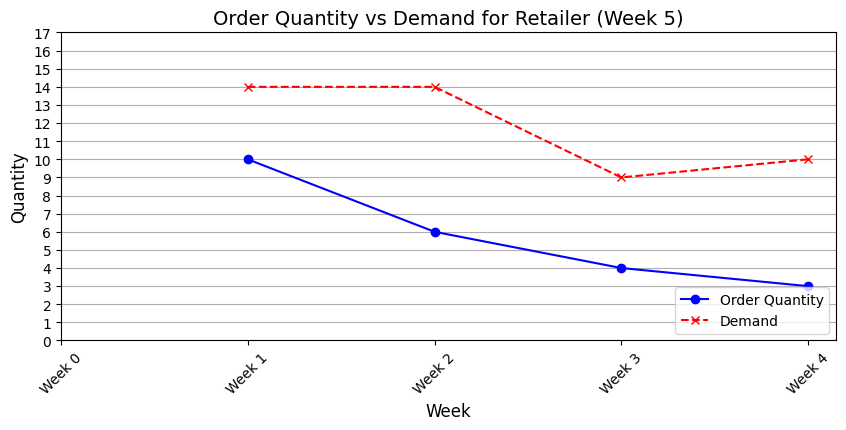

Using approach: Manual
Enter the order quantity manually: 1
Using approach: average
Average Demand: 8
Using approach: average
Average Demand: 10
Using approach: average
Average Demand: 8
Using approach: average
Average Demand: 7
Using approach: average
Average Demand: 6
Using approach: average
Average Demand: 8
Using approach: average
Average Demand: 8
Using approach: average
Average Demand: 9
Using approach: average
Average Demand: 9
Using approach: average
Average Demand: 8
Using approach: average
Average Demand: 10
Using approach: average
Average Demand: 8
Using approach: average
Average Demand: 8
Using approach: average
Average Demand: 8
Using approach: average
Average Demand: 8


Week,Role,Inventory,Incoming Shipping
0,Retailer,10,"[(5, 1)]"
1,Retailer,10,"[(10, 2)]"
2,Retailer,1,"[(6, 3)]"
3,Retailer,0,"[(4, 4)]"
4,Retailer,0,"[(3, 5)]"
5,Retailer,0,"[(1, 6)]"


Week,Role,Order Quantity,Demand,Excess Inventory,Backorder,Holding Cost,Backorder Cost,Total Cost
0,Retailer,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Retailer,10.0,14.0,1.0,0.0,1.0,0.0,1
2,Retailer,6.0,14.0,0.0,3.0,0.0,6.0,7
3,Retailer,4.0,9.0,0.0,3.0,0.0,6.0,13
4,Retailer,3.0,10.0,0.0,6.0,0.0,12.0,25
5,Retailer,1.0,11.0,0.0,8.0,0.0,16.0,41


In [13]:
# Generate and display the supply chain tables for all roles with detailed summary
all_tables = generate_supply_chain_table_for_all_roles(detailed_summary=True)

In [14]:
from google.colab import files
import time
import pytz
from datetime import datetime

# Assuming `all_tables` is a dictionary and you want the "Retailer" table
retailer_table = pd.concat(all_tables["Retailer"], axis=1)  # Combine table_part1 and table_part2 for Retailer

# Add 'username' and 'approach' columns
retailer_table['username'] = name_input.value  # Add username column
retailer_table['approach'] = approach_input.value  # Add approach column

# Get the current time in EST
est = pytz.timezone('US/Eastern')
current_time_est = datetime.now(est).strftime("Time:%H-%M-%S")  # Format time as HH-MM-SS in EST

# Generate the file name using name_input, approach_input, and EST time
file_name = f"{name_input.value}_{approach_input.value}_{current_time_est}_retailer_table.csv"

# Save the Retailer table to a CSV file
retailer_table.to_csv(file_name, index=False)

# Download the file
files.download(file_name)
print(f"Retailer table saved and ready for download: {file_name}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Retailer table saved and ready for download: User_Manual_Time:03-34-50_retailer_table.csv
